# Project Proposal - Speed Dating 

We acquired data from Columbia Business School Professors Ray Fisman and Sheena Iyengar's speed dating experiment from 2002 to 2004. The data collects an individual's experience at a speed dating event. It also includes questionnaire data gathered throughout various stages of the event, during, halfway, few days after, and a few weeks after

### Installing Packages and Loading Data

In [3]:
# install.packages('skimr')
# install.packages('tidyr')
# install.packages('ggplot2')
# install.packages('ggcorrplot')
# install.packages('mice')
# install.packages('data.table')

data_source = 'http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/'

options(repr.matrix.max.cols=200, repr.matrix.max.rows=200) #extend view of columns

#attaching packages
library(skimr)
library(dplyr)
library(ggplot2)
library(ggcorrplot)
library(mice)
library(data.table)

In [4]:
### load data to ensure loaded properly
path = 'Speed Dating Data.csv'
df = read.csv(path)
print(dim(df))
head(df)

Warning message in file(file, "rt"):
“cannot open file 'Speed Dating Data.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


### Initial Review - Thoughts and Data Cleaning
The data has 8378 rows and 195 columns. Reviewing the first few rows, it seems that each row represents a date for a particular individual and it repeats for every date that person has. Then it shows the repeated characteristics of the individual for their own perception or characteristics for every speed date they have. There are some considerations with this data structure, there may be users with varying frequencies of dates of results and for empty values of same individuals could be imputed. For each date, they score their date and determine if they are a match (1 for yes and 0 for no). There are some demographic of the individual and the potential speed date. The data collects characteristic qualities: Attractive, Sincere, Intelligent, Fun, Ambitious, Has shared interests/hobbies that the individual rates others and themselves. We can potentially separate these for different use cases as well as make comparisons between individual's personal ratings and the partner's ratings.

Due to the size, we need to review the summary statistics on skimr to identify the distribution and null values. Moreover, we will attempt several different methods to reduce the number of columns to make it simple. First, reading the key list, we determine the relevant data that could provide insights and remove potential duplicates to reduce the number of columns. Second, we will subset the data for different use case. Between the subsets we can review the highly correlated data and remove them. Then, we can also decide on inputing missing values if it makes sense. Finally, for values we cannot impute, we will remove the rows with many missing values. 

In [5]:
### skim package to view summary statistics
skim(df)

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             5000  
Number of columns          7     
_______________________          
Column type frequency:           
  character                2     
  logical                  3     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 age_group             0             1     3     5     0        4          0
2 country               0             1     2     9     0        4          0

── Variable type: logical ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean count               
1 female                0             1 0.573  TRU: 2863, FAL: 2137
2 subscribed_30         0             1 0.0552 FAL:

### Important Feature Descriptions and Explanation

#### Person's Data

##### Unique Identifiers
- id: subject within the wave 

- iid: subject number and group (wave id and gender)

- idg: subject number within gender group(id gender)
##### Study Setting

- dec: Decision 1= yes, 0 = no to a date

- Wave: Date of speed dating event. Wave 6-9 has a 10 scale (changed to 100 pt scale by proportion), remainder has 100 pt allocation. Each wave has different number of male and female.

- condtn: 1 = limited choice, 2 = extensive choice 

- round:		number of people that met in wave

- position:  	station number where met partner 

- positin1:	station number where started 

- order: 		the number of date that night when met partner

- match: 1=yes, 0=no


##### Demographic Data  
- career_c: career coded 
    - distibution of career and relation to decision of a date

- gender: female = 0, male = 0 

- age:

- form: country prior to Columbia

- field: field of study  

- zipcode: zipcode of growth

##### Psychographic Data  

- Goal: Described intention of what they go to the event for the event
    - distribution for those coming to an event and we can potentially then cluster these groups

- date: frequency of going on a date categorized 

- go out: frequency of going out (not necessarily dates) 

- imprace: importance on a scale of 1 -10, same race/ethnic background

- imprelig: importance on a scale of 1    -10, same relgion

- Activities: sports, tvsports, excersice, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga
    - relationship between interested activities to decision 

#### Partner's Data
##### Unique Identifiers
- id: subject within the wave 

- iid: subject number and group (wave id and gender)

- idg: subject number within gender group(id gender)

- partner: 	partner’s id number the night of event

- pid: 		partner’s iid number
##### Demographic Data
- samerace:  	participant and the partner were the same race. 1= yes, 0=no

- age_o:		age of partner

- race_o:		race of partner

- pf_o_att: 	partner’s stated preference at Time 1 (attr1_1) for all 6 attributes

- dec_o: 		decision of partner the night of event

- attr_o: 	rating by partner the night of the event, for all 6 attributes


#### Characteristics Keys

Characteristics that need to add up to 100 defining the most important  - attr1_1    - Attractive, sinc1_1  - Sincere, intel1_1  - Intelligent, fun1_1    - Fun, amb1_1  - Ambitious, shar1_1     - Has shared interests/hobbies
    - Identify most popular types of characteristics perceptions 

- Different keys for characteristics: characterx_y, (x = key, y = period asked{1:"During event", 2: "days after event", 3: "weeks after sent matches"})
    - sinc1_1   - represent one's own perception on important of sincerity
    - sinc2_1   - represents one's perception on partner's important of sincerity 
    - sinc3_1   - represents one's opinion on how they measure up on sincerity
    - sinc4_1   - represents one's opinion on how others perceive you on sincerity 

- int_corr: correlation between participant’s and partner’s ratings of interests in 			



### Data Exploration - Demographic Data & Study Participants

In [2]:
### Match & Decision by Partner and Person
df %>%
    select(pid,dec,dec_o,match) %>% 
    mutate(decision = case_when(
        dec == 1 & dec_o == 1 & match == 1      ~ "all_matched",
        (dec == 1 | dec_o == 1) & match == 0    ~ "one_dec_all_matched",
        dec == 1 & dec_o == 1 & match == 0      ~ "all_dec_no_matched",
        (dec == 1 | dec_o == 1) & match == 0    ~ "one_dec_no_matched",
        TRUE                                    ~ "no_match"
    )) %>% 
    group_by(decision) %>% 
    count() %>% 
    ungroup() %>%
    arrange(desc(decision))%>%
    mutate(col_percent = round(100*n/sum(n))) %>%
    mutate(ypos = cumsum(col_percent)- 0.5*col_percent) %>%
    # ungroup()
    ggplot(., aes(x = "", y= col_percent, fill=decision)) +
    
    geom_bar(stat="identity", width = 1) +
    coord_polar("y", start = 0) +
    theme_void() +
    geom_text(aes(y = ypos, label = col_percent), color = "white", size=6) + 
    ggtitle("Matched Proportion")

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `pid` doesn't exist.


It seems that only 16% can find mutual matches where both liked each other, 33% has a one-sided match while 51% didn't match at all. 

Warning message:
“Removed 82 rows containing non-finite values (stat_count).”


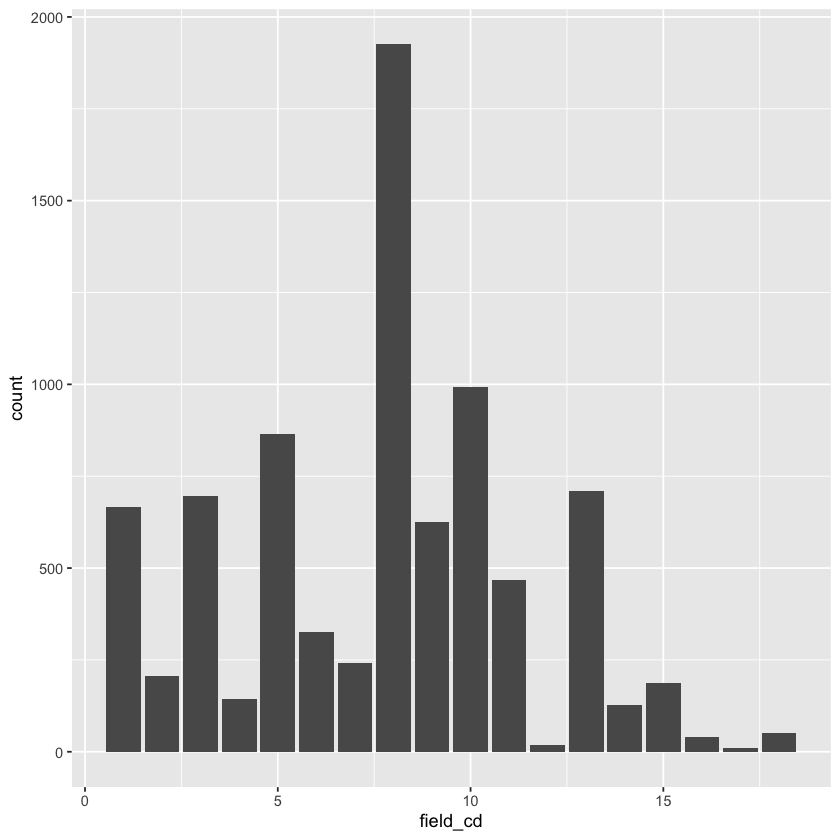

In [105]:
### field distribution vs field_cd 
ggplot(data=df, mapping = aes(x=field_cd)) +
    geom_bar()

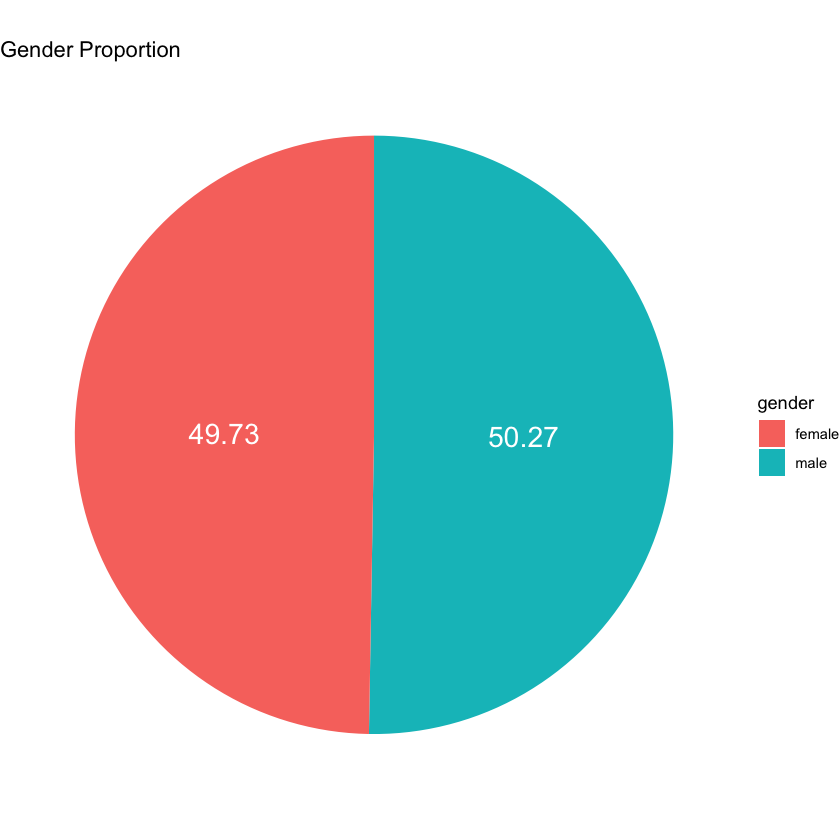

In [112]:
### Proportion of Participant's Gender
df %>%
    select(iid,gender) %>%
    filter(!duplicated(iid)) %>%
    mutate(gender = case_when(
        gender == 0 ~ "female",
        gender == 1 ~ "male",
        TRUE ~ "prefer_not_to_disclose"
    )) %>% 
    group_by(gender) %>% 
    count() %>% 
    ungroup() %>%
    arrange(desc(gender))%>%
    mutate(col_percent = round(100*n/sum(n),2)) %>%
    mutate(ypos = cumsum(col_percent)- 0.5*col_percent) %>%
    ggplot(., aes(x = "", y= col_percent, fill=gender)) +
        geom_bar(stat="identity", width = 1) +
        coord_polar("y", start = 0) +
        theme_void() +
        geom_text(aes(y = ypos, label = col_percent), color = "white", size=6) + 
        ggtitle("Gender Proportion")

Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


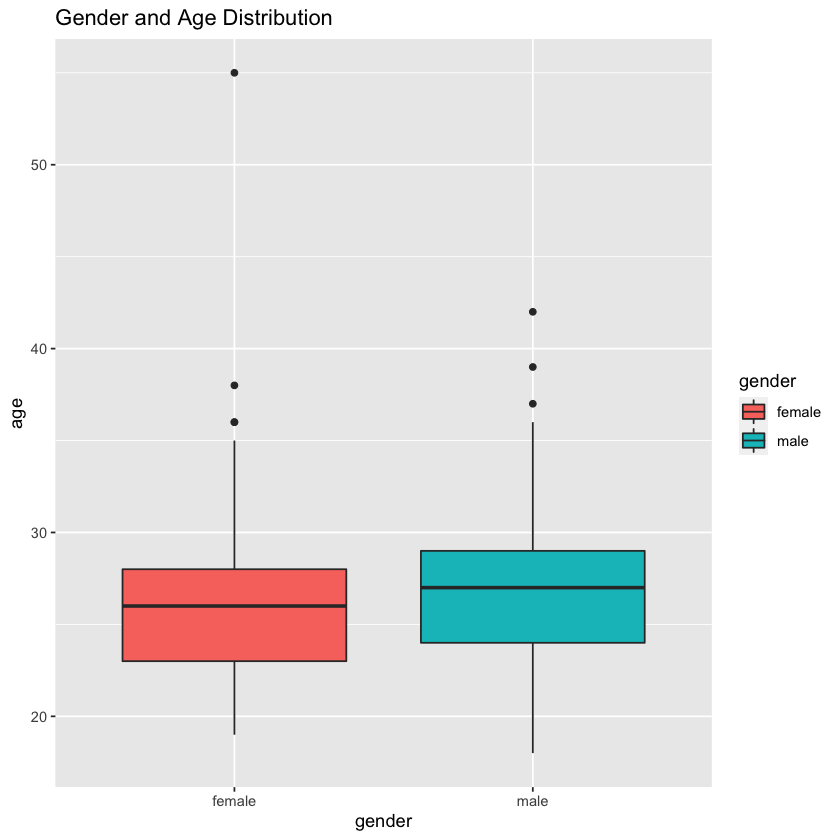

In [162]:
### Age Distribution
df %>%
    select(iid,gender,age) %>%
    filter(!duplicated(iid)) %>%
    mutate(gender = case_when(
        gender == 0 ~ "female",
        gender == 1 ~ "male",
        TRUE ~ "prefer_not_to_disclose"
    )) %>% 
    ggplot(., aes(x=gender, y= age , fill=gender)) + 
        geom_boxplot() + 
        ggtitle("Gender and Age Distribution")


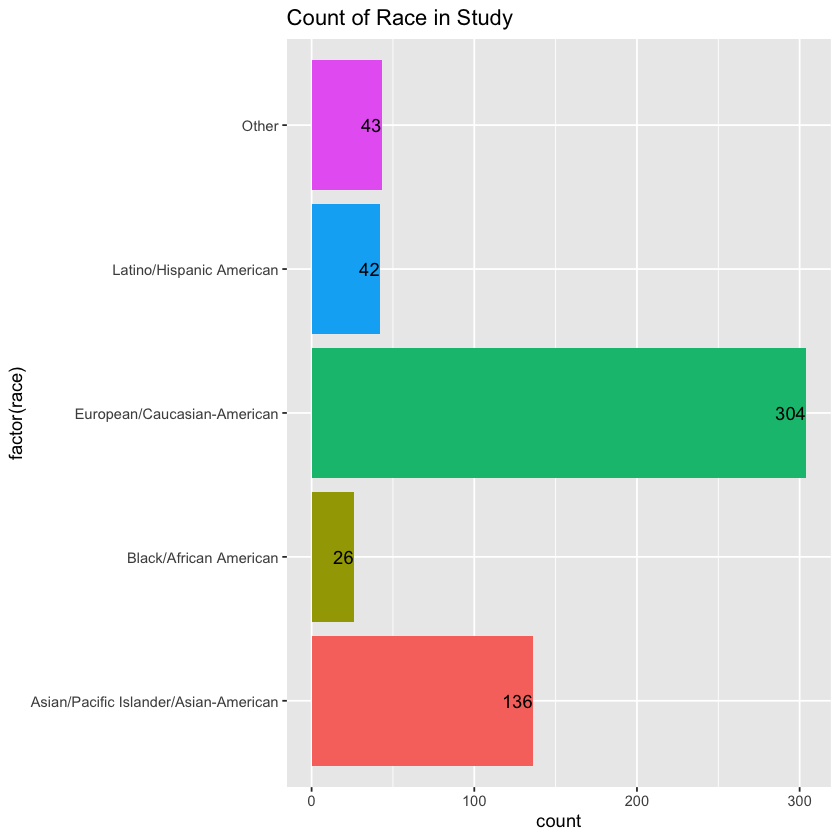

In [164]:
### Distribution of Race
df %>% 
    select(iid, race) %>%
    filter(!duplicated(iid)) %>%
    mutate(race = case_when( 
        race == 1 ~ "Black/African American",
        race == 2 ~ "European/Caucasian-American",
        race == 3 ~ "Latino/Hispanic American",
        race == 4 ~ "Asian/Pacific Islander/Asian-American",
        race == 5 ~ "Native American",
        TRUE ~ "Other" )) %>%
    ggplot(., aes(x=factor(race), fill = factor(race))) + 
        geom_bar() +
        geom_text(aes(label= ..count..), stat = "count", hjust = 1)+
        coord_flip() +
        theme(legend.position = "none") + 
        ggtitle("Count of Race in Study")


### Data Cleaning - Considerations for cleaning and removal:
- Duplicate fields removal (if any)
- Imputing data entry mistakes (if any)
- Columns with many null values
- Separate by survey time periods - Subset:
    - Halfway through the event request for importance in attributes in a potential date (ends with "1_s"), and your own attribute (ends with "3_s")
    - Followup/Time2 - correspond with a survey days after the event, to receive the matches (marked with "x_2" original keys during event and 2 at the end). Do we care if they reply after the event or do we care about on the event? 
    - Followup2/Time3 - correspond with a survey weeks after they receive matches (marked with "x_3" at the end). Do we care if they reply after the event or do we care about on the event? 


In [16]:
### checking for duplicated rows -- Great! No Duplicate Rows 
sum(duplicated(df))

[1] 0

In [137]:
### imputing data that should be duplicated -- Great! All fields are properly inputed with the same personal information
df %>% 
    select(iid, any_of(personal)) %>%
    filter(!duplicated(iid)) %>%
    group_by(iid) %>%
    count() %>%
    filter(n>1)

iid,n
<int>,<int>


#### Subsetting Data 
Given our use cases is mainly focused on the individual during the event, we will exclude the features that are only relevant to the individual and partner's characteristics.

In [218]:
# writing vectors of data_groupings
personal = c("iid", "wave",
            "gender", "age", "field", 
            "field_cd","race", "imprace", 
            "imprelig", "from", "zipcode", 
            "income", "goal", "date", 
            "go_out", "career", "career_c", 
            "sports", "tvsports", "exercise", 
            "dining", "museums", "art", 
            "hiking", "gaming", "clubbing", 
            "reading", "tv", "theater",
            "movies", "concerts", "music", 
            "shopping", "yoga", "exphappy",
            "expnum", "match_es")

partner = c("pid",
            "age_o","race_o","pf_o_att",
            "pf_o_sin","pf_o_int","pf_o_fun",
            "pf_o_amb","pf_o_sha","dec_o",
            "attr_o","sinc_o","intel_o",
            "fun_o","amb_o","shar_o",
            "like_o","prob_o","met_o","go_out")
id_fields = c("pid", "iid")
### Pre-select data to remove due to high null values or unimportant to final analysis
# remove_data = c( "undergra", "mn_sat", "tuition", "income", "positin1", "expnum")

In [219]:
#creating a subset from the dataset to use for final analysis
personal_df <- df %>%
    select(any_of(append(personal,partner)))
dim(personal_df)
head(personal_df)

[1] 8378   56

,iid,wave,gender,age,field,field_cd,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,match_es,pid,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,11,27,2,35,20,20,20,0,5,0,6,8,8,8,8,6,7,4,2
2,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,12,22,2,60,0,0,40,0,0,0,7,8,10,7,7,5,8,4,2
3,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,13,22,4,19,18,19,18,14,12,1,10,10,10,10,10,10,10,10,1
4,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,14,23,2,30,5,15,40,5,5,1,7,8,9,8,9,8,7,7,2
5,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,15,24,3,30,10,20,10,10,20,1,8,7,9,6,9,7,8,6,2
6,1,1,0,21,Law,1,4,2,4,Chicago,"60,521","69,487.00",2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,2,4,16,25,2,50,0,30,10,0,10,1,7,7,8,8,7,7,7,6,2


In [230]:
skim(personal_df)

── Data Summary ────────────────────────
                           Values     
Name                       personal_df
Number of rows             8378       
Number of columns          51         
_______________________               
Column type frequency:                
  character                3          
  numeric                  48         
________________________              
Group variables            None       

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 field                 0             1     0    56    63      220          0
2 from                  0             1     0    58    79      245          0
3 career                0             1     0    77    89      326          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd    p0    p25   p50
 1 iid           

In [231]:
### removing columns with more than 1000 null values cutting the number of columns from 56 -> 51
dim(personal_df)
personal_df <- personal_df[, colSums(is.na(personal_df))<1000]
personal_df <- personal_df %>%
                select(!contains(c("zipcode", "income")))
dim(personal_df)
head(personal_df)

[1] 8378   51

[1] 8378   51

,iid,wave,gender,age,field,field_cd,race,imprace,imprelig,from,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,pid,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,like_o,prob_o,met_o
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,11,27,2,35,20,20,20,0,5,0,6,8,8,8,8,7,4,2
2,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,12,22,2,60,0,0,40,0,0,0,7,8,10,7,7,8,4,2
3,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,13,22,4,19,18,19,18,14,12,1,10,10,10,10,10,10,10,1
4,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,14,23,2,30,5,15,40,5,5,1,7,8,9,8,9,7,7,2
5,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,15,24,3,30,10,20,10,10,20,1,8,7,9,6,9,8,6,2
6,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,NA,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,16,25,2,50,0,30,10,0,10,1,7,7,8,8,7,7,6,2


In [232]:
#consistency in cases for string fields
personal_df <- personal_df %>%
                mutate(field = tolower(field), 
                        from = tolower(from), 
                        career = tolower(career))

In [233]:
#impute the missing data with mice
personal_mice = mice::complete(mice(personal_df,seed = 123))
skim(personal_mice)


 iter imp variable
  1   1  age  field_cd  race  imprace  imprelig  goal  date  go_out  career_c  sports  tvsports  exercise  dining  museums  art  hiking  gaming  clubbing  reading  tv  theater  movies  concerts  music  shopping  yoga  exphappy  pid  age_o  race_o  pf_o_att  pf_o_sin  pf_o_int  pf_o_fun  pf_o_amb  pf_o_sha  attr_o  sinc_o  intel_o  fun_o  amb_o  like_o  prob_o  met_o
  1   2  age  field_cd  race  imprace  imprelig  goal  date  go_out  career_c  sports  tvsports  exercise  dining  museums  art  hiking  gaming  clubbing  reading  tv  theater  movies  concerts  music  shopping  yoga  exphappy  pid  age_o  race_o  pf_o_att  pf_o_sin  pf_o_int  pf_o_fun  pf_o_amb  pf_o_sha  attr_o  sinc_o  intel_o  fun_o  amb_o  like_o  prob_o  met_o
  1   3  age  field_cd  race  imprace  imprelig  goal  date  go_out  career_c  sports  tvsports  exercise  dining  museums  art  hiking  gaming  clubbing  reading  tv  theater  movies  concerts  music  shopping  yoga  exphappy  pid  age_o  ra

Warning message:
“Number of logged events: 28”


── Data Summary ────────────────────────
                           Values       
Name                       personal_mice
Number of rows             8378         
Number of columns          51           
_______________________                 
Column type frequency:                  
  character                3            
  numeric                  48           
________________________                
Group variables            None         

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 field                 0             1     0    56    63      220          0
2 from                  0             1     0    58    79      245          0
3 career                0             1     0    77    89      326          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd    p0    p25   p

In [234]:
#final data
head(personal_mice)

,iid,wave,gender,age,field,field_cd,race,imprace,imprelig,from,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,pid,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,like_o,prob_o,met_o
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,1,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,11,27,2,35,20,20,20,0,5,0,6,8,8,8,8,7,4,2
2,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,4,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,12,22,2,60,0,0,40,0,0,0,7,8,10,7,7,8,4,2
3,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,4,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,13,22,4,19,18,19,18,14,12,1,10,10,10,10,10,10,10,1
4,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,1,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,14,23,2,30,5,15,40,5,5,1,7,8,9,8,9,7,7,2
5,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,1,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,15,24,3,30,10,20,10,10,20,1,8,7,9,6,9,8,6,2
6,1,1,0,21,law,1,4,2,4,chicago,2,7,1,lawyer,4,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,3,16,25,2,50,0,30,10,0,10,1,7,7,8,8,7,7,6,2


### Closing Remarks and Furthur Examination
This was the first attempt to clean the data, there are several features that could be further cleaned depending on final use for analysis. Examples could be the "from" field which contains differing and multiple locations. Income could potentially be included by cleaning zipcode and comparing to the US Census. Career and Field could also be cleaned further to ensure standardization or simply using the coded fields for generalizations.

In [239]:
### creating clean output file
fwrite(personal_mice, 'cleaned_data.csv')